In [2]:
import torch
from transformers import AutoModel, AutoTokenizer
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torch.nn as nn
import psycopg2
import matplotlib.pyplot as plt
import math

/Users/konstantinos/Desktop/virtualenvs/codegrid/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### Load dataset

In [3]:
func_data = pd.read_csv('/Users/konstantinos/Desktop/Clone Generalization/binary files/bcb_funcs_all.tsv', sep='\t', header=None)

func_data = func_data.rename(columns={0:'id', 1:'func'})

pairs_file = '/Users/konstantinos/Desktop/Clone Generalization/binary files/bcb_pair_ids.pkl'
pairs_data = pd.read_pickle(pairs_file)

# Merge pairs_data and data based on "id1" and "id"
data = pairs_data.merge(func_data, left_on='id1', right_on='id', how='left')

# Rename the 'func' column to 'func1'
data.rename(columns={'func': 'func1'}, inplace=True)

# Drop the 'id' column (if you want to remove it)
data.drop('id', axis=1, inplace=True)

# Merge again for the second function (func2) based on "id2" and "id"
data = data.merge(func_data, left_on='id2', right_on='id', how='left')

# Rename the 'func' column to 'func2'
data.rename(columns={'func': 'func2'}, inplace=True)

# Drop the 'id' column (if you want to remove it)
data.drop('id', axis=1, inplace=True)

# Keep only semantic clones
data = pd.concat([data[data['label']==0], data[data['label']==4]])

In [4]:
data

,id1,id2,label,func1,func2
77535,21392041,23677115,0,public RegisterableChannel getChannel(...,"\tpublic static void copyFile2(File srcFile, F..."
77536,7326867,23677118,0,void doOpenUserGuideUrl(boolean online) {\...,"\tpublic static void copyFile5(File srcFile, F..."
77537,9360918,23677115,0,@Override\n public void onSucce...,"\tpublic static void copyFile2(File srcFile, F..."
77538,513859,23677115,0,public void writeInput(File inputFile) {\n...,"\tpublic static void copyFile2(File srcFile, F..."
77539,9706513,23677115,0,public synchronized SocketChannel getChann...,"\tpublic static void copyFile2(File srcFile, F..."
...,...,...,...,...,...
57530,9884136,23677117,4,private void doAddPresence(AddPresence msg...,"\tpublic static void copyFile4(File srcFile, F..."
57531,7906813,23677116,4,private void refreshLayout() {\n fo...,"\tpublic static void copyFile3(File srcFile, F..."
57532,2933758,23677116,4,public void restoreAllChannelsToInitDelay(...,"\tpublic static void copyFile3(File srcFile, F..."
57533,18322909,23677111,4,@Override\n public void run() {\n ...,\tpublic static String downloadWebpage1(String...


In [5]:
# Database connection parameters
db_params = {
    "host": "localhost",        # Replace with your PostgreSQL host
    "database": "bcb",      # Replace with your database name
    "user": "konstantinos",        # Replace with your username
    "password": "1234" # Replace with your password
}

# Establish a database connection
conn = psycopg2.connect(**db_params)

In [6]:
functionalities_sql = pd.read_sql_query("SELECT * FROM functionalities", conn)

/var/folders/j9/k05ysrr550d9bhp1ns50p1hm0000gn/T/ipykernel_24279/697513364.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  functionalities_sql = pd.read_sql_query("SELECT * FROM functionalities", conn)


In [7]:
# Replace 'your_schema' and 'your_table' with the actual schema and table names
query = """
    SELECT * FROM clones;
"""

# Fetch data from the clones table into a Pandas DataFrame
clones_df = pd.read_sql_query(query, conn)


# Replace 'your_schema' and 'your_table' with the actual schema and table names
query = """
    SELECT * FROM false_positives;
"""

# Fetch data from the clones table into a Pandas DataFrame
false_clones_df = pd.read_sql_query(query, conn)

/var/folders/j9/k05ysrr550d9bhp1ns50p1hm0000gn/T/ipykernel_24279/2828375149.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  clones_df = pd.read_sql_query(query, conn)
/var/folders/j9/k05ysrr550d9bhp1ns50p1hm0000gn/T/ipykernel_24279/2828375149.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  false_clones_df = pd.read_sql_query(query, conn)


In [13]:
# Merge the Pandas DataFrame (df) with the clones DataFrame using the 'id1' and 'function_id_one' columns
result_df = pd.merge(data, clones_df, left_on='id1', right_on='function_id_one', how='left')

In [16]:
data.head()

,id1,id2,label,func1,func2
77535,21392041,23677115,0,public RegisterableChannel getChannel(...,"\tpublic static void copyFile2(File srcFile, F..."
77536,7326867,23677118,0,void doOpenUserGuideUrl(boolean online) {\...,"\tpublic static void copyFile5(File srcFile, F..."
77537,9360918,23677115,0,@Override\n public void onSucce...,"\tpublic static void copyFile2(File srcFile, F..."
77538,513859,23677115,0,public void writeInput(File inputFile) {\n...,"\tpublic static void copyFile2(File srcFile, F..."
77539,9706513,23677115,0,public synchronized SocketChannel getChann...,"\tpublic static void copyFile2(File srcFile, F..."


In [17]:
clones_df.head()

,function_id_one,function_id_two,functionality_id,type,syntactic_type,similarity_line,similarity_token,min_size,max_size,min_pretty_size,max_pretty_size,min_judges,min_confidence,min_tokens,max_tokens,internal
0,647224,13563706,4,tagged-tagged,3,0.053333,0.113567,18,150,20,150,1,1,181,1312,False
1,13563706,17930256,4,tagged-tagged,3,0.100000,0.192835,39,150,39,150,1,1,348,1312,False
2,1458629,13563706,4,tagged-tagged,3,0.080000,0.113567,27,150,27,150,1,1,193,1312,False
3,13563706,22602225,4,tagged-tagged,3,0.033333,0.070884,11,150,12,150,1,1,112,1312,False
4,8273323,13563706,4,tagged-tagged,3,0.013333,0.035061,6,150,6,150,1,1,49,1312,False


In [26]:
clones_data = data[data['label']==4]
false_clones_data = data[data['label']==0]

In [41]:
import math

### True clones

In [79]:
clones_df = clones_df.rename(columns={"function_id_one": "id1", "function_id_two": "id2"})

In [80]:
clones_merged = pd.merge(clones_data, clones_df[['id1', 'id2', 'functionality_id']], on=['id1', 'id2'], how='left')

In [81]:
len(clones_merged)

20000

In [67]:
for i in range(len(clones_data)):
    if i%100 == 0:
        print(i)
    id1 = clones_merged['id1'].iloc[i]
    id2 = clones_merged['id2'].iloc[i]
    idx = np.array(clones_df['id1']==id1) & np.array(clones_df['id2']==id2)
    if sum(idx) > 1:
        print("Two fcn ids:")
        print(i)
    if sum(idx) <1:
        print("No fcn id:")
        print(i)

0
100
200
300
400
Two fcn ids:
455
Two fcn ids:
456
500
600
700
800
900
1000
1100
1200


KeyboardInterrupt: 

In [62]:
i

455

In [63]:
clones_merged.iloc[i]

id1                                                          12783713
id2                                                          16583451
label                                                               4
func1                   @Override\n    public void sendErrorMessag...
func2                   private static void setEnvEntry(File fromE...
functionality_id                                                  4.0
Name: 455, dtype: object

In [65]:
clones_df[np.array(clones_df['id1']==12783713) & np.array(clones_df['id2']==16583451)]

,id1,id2,functionality_id,type,syntactic_type,similarity_line,similarity_token,min_size,max_size,min_pretty_size,max_pretty_size,min_judges,min_confidence,min_tokens,max_tokens,internal
1939738,12783713,16583451,4,tagged-tagged,3,0.32,0.694581,24,25,24,25,1,1,196,203,False
5574562,12783713,16583451,30,tagged-tagged,3,0.32,0.694581,24,25,24,25,1,1,196,203,False


In [69]:
clones_data[np.array(clones_data['id1']==19152293) & np.array(clones_data['id2']==23677145)]

,id1,id2,label,func1,func2
57534,19152293,23677145,4,public static void main(String args[]) thr...,\tpublic static <T extends Comparable<T>> void...


In [70]:
# This is marked as non-clone in the SQL
clones_df[np.array(clones_df['id1']==19152293) & np.array(clones_df['id2']==23677145)]

,id1,id2,functionality_id,type,syntactic_type,similarity_line,similarity_token,min_size,max_size,min_pretty_size,max_pretty_size,min_judges,min_confidence,min_tokens,max_tokens,internal


In [90]:
clones_merged = clones_merged.drop_duplicates(subset=['id1', 'id2'])

# Step 2: Drop rows where 'functionality_id' is NaN
clones_merged = clones_merged.dropna(subset=['functionality_id'])

In [91]:
clones_merged

,id1,id2,label,func1,func2,functionality_id
0,2279291,7895612,4,public static String encrypt(String plainT...,public final String encrypt(String input) ...,3.0
1,10654982,17444336,4,public static String getEncryptedPassword(...,public static synchronized String encrypt(...,3.0
2,6305269,14770729,4,"protected void copyFile(File sourceFile, F...","public static boolean joinFiles(File dest,...",4.0
3,3621790,7386971,4,private String sha1(String s) {\n S...,public String hash(String senha) {\n ...,3.0
4,10828162,21393871,4,public static String loadURLToString(Strin...,public String call() throws Exception {\n ...,2.0
...,...,...,...,...,...,...
18395,19121580,19395766,4,public static String toMd5(String s) {\n ...,public static String encodePassword(String...,3.0
18396,4774514,9024096,4,protected synchronized String encryptThis(...,public static final String enCode(String a...,3.0
18397,6527977,10878062,4,"public static void copy(File in, File out)...","public static void copy(File source, File ...",4.0
18398,9399634,14024978,4,protected static String fileName2md5(Strin...,public static final String generate(String...,3.0


### False clones

In [85]:
false_clones_df = false_clones_df.rename(columns={"function_id_one": "id1", "function_id_two": "id2"})

In [86]:
false_clones_merged = pd.merge(false_clones_data, false_clones_df[['id1', 'id2', 'functionality_id']], on=['id1', 'id2'], how='left')

In [87]:
len(false_clones_merged)

20000

In [92]:
false_clones_merged = false_clones_merged.head(len(clones_merged))

In [93]:
data = pd.concat([clones_merged, false_clones_merged])

In [94]:
data.groupby('functionality_id').size()

functionality_id
2.0      4286
3.0      7617
4.0     21716
6.0       342
7.0      1435
8.0         9
9.0        74
10.0     1320
30.0        1
dtype: int64

In [98]:
data.to_pickle('/Users/konstantinos/Desktop/Clone Generalization/binary files/bcb_1vsAll/bcb_v2_sampled.pickle')

In [21]:
data['func1'].iloc[0]

'        public RegisterableChannel getChannel() {\n            return runnable.getChannel();\n        }\n'

In [47]:
t = data.apply(lambda x: str(x['func1']).strip().startswith('public static void copyFile') and str(x['func2']).strip().startswith('public static void copyFile'), axis=1)


In [74]:
t = data.apply(lambda x: str(x['func1']).strip()[0:280] == str(x['func2']).strip()[0:280], axis=1)


In [76]:
i = 0
print(data[t]['func1'].iloc[i])
print(data[t]['func2'].iloc[i])

    public static void copyFiles(String strPath, String dstPath) throws IOException {
        File src = new File(strPath);
        File dest = new File(dstPath);
        if (src.isDirectory()) {
            dest.mkdirs();
            String list[] = src.list();
            for (int i = 0; i < list.length; i++) {
                String dest1 = dest.getAbsolutePath() + File.separatorChar + list[i];
                String src1 = src.getAbsolutePath() + File.separatorChar + list[i];
                copyFiles(src1, dest1);
            }
        } else {
            FileInputStream fin = new FileInputStream(src);
            FileOutputStream fout = new FileOutputStream(dest);
            int c;
            while ((c = fin.read()) >= 0) fout.write(c);
            fin.close();
            fout.close();
        }
    }

    public static void copyFiles(String strPath, String dstPath) throws IOException {
        File src = new File(strPath);
        File dest = new File(dstPath);
        if (s

In [57]:
print(data[t]['func2'].iloc[2])
print(data[t]['func2'].iloc[1])

	public static void copyFile2(File srcFile, File destFile) throws IOException {
		FileUtils.copyFile(srcFile, destFile);
	}

	public static void copyFile4(File srcFile, File destFile) throws IOException {
		InputStream in = new FileInputStream(srcFile);
		OutputStream out = new FileOutputStream(destFile);
		IOUtils.copy(in, out);
		in.close();
		out.close();
	}



In [49]:
data['func1'].iloc[0]

'        public RegisterableChannel getChannel() {\n            return runnable.getChannel();\n        }\n'

In [10]:
data[data['id1']==11372191]

,id1,id2,label,func1,func2
93246,11372191,23677117,0,protected InnerZipStreamDataNode(String pa...,"\tpublic static void copyFile4(File srcFile, F..."


In [11]:
# Create a dictionary mapping function_id_one to functionality_id for faster lookups
functionality_id_mapping11 = clones_df.groupby('function_id_one')['functionality_id'].max().to_dict()
functionality_id_mapping12 = clones_df.groupby('function_id_two')['functionality_id'].max().to_dict()
functionality_id_mapping1 = functionality_id_mapping11 | functionality_id_mapping12

functionality_id_mapping21 = false_clones_df.groupby('function_id_one')['functionality_id'].max().to_dict()
functionality_id_mapping22 = false_clones_df.groupby('function_id_two')['functionality_id'].max().to_dict()
functionality_id_mapping2 = functionality_id_mapping21 | functionality_id_mapping22

# Use map to efficiently get functionality_ids based on function_id
functionality_ids1 = data['id1'].map(functionality_id_mapping1).tolist()[20000:]
functionality_ids2 = data['id1'].map(functionality_id_mapping2).tolist()[:20000]

In [12]:
for (i,x) in enumerate(functionality_ids1):
    if math.isnan(x):
        try:
            functionality_ids1[i] =  functionality_id_mapping1[data['id1'].iloc[i]]
        except:
            functionality_ids1[i] =  functionality_id_mapping1[data['id2'].iloc[i]]


In [13]:
functionality_ids = functionality_ids1 + functionality_ids2

In [14]:
set(functionality_ids)

{2.0,
 3.0,
 4.0,
 6.0,
 7.0,
 8.0,
 9,
 10.0,
 14.0,
 18,
 22.0,
 25.0,
 26.0,
 27.0,
 28.0,
 30.0,
 33.0,
 34,
 37.0,
 39.0,
 43.0,
 45.0}

In [15]:
len(set(functionality_ids))

22

In [16]:
functionality_names = [functionalities_sql['name'][functionalities_sql['id'] == x] for x in set(functionality_ids)]

In [17]:
functionalities_sql = functionalities_sql.sort_values('id')

In [18]:
functionalities_sql

,name,description,id,search_heuristic
0,Download From Web,Downloads file from http link.,2,(openStream AND URL) OR (openConnection AND UR...
1,Secure Hash,1. Generate secure hash in binary format. 2. ...,3,.*\.\s*digest\s*\(.*
2,Copy File,Copies a file.,4,[getChannel] OR [transferFrom] OR [FileUtils.c...
3,Decompress zip archive.,"1. Retrieve a zip archive (from disk, internet...",5,Pattern#1: .*\.\s*getNext((Zip)|)Entry\s*\(\s*...
4,Connect to FTP Server,1 - Connect to the FTP server. 2 - Log in wit...,6,\.\s*connect\s*\( AND \.\s*login\s*\(
5,Bubble Sort Array,Sorts an array of values using bubble sort.,7,[a-z]\[[a-z]\] = [a-z]\[[a-z]+1\]
34,Setup SGV,1 - Create ScrollingGraphicalViewer object. 2 ...,8,ScrollingGraphicalViewer
33,Setup SGV Event Handler,"1-Create scrollinggraphicalviewer, 2-Add liste...",9,GraphicalVeiwer
6,Execute update and rollback.,1 - Execute a database update. 2 - Rollback (...,10,executeUpdate\s*\( AND rollback\s*\(\s*\)
7,Initialize Java Eclipse Project.,1-Get eclipse project (create or receive). 2-...,11,setNatureIds AND setOutputLocation AND setRawC...


# BCB v2 sampled - BF

In [19]:
from tqdm import tqdm
from gensim.models import Word2Vec
import time
import pandas as pd
import pickle
from tqdm import tqdm
from gensim.models import Word2Vec, KeyedVectors
import torch
import torch.multiprocessing
import sys
from tqdm import tqdm
from gensim.models import Word2Vec
import torch
import torch.multiprocessing
from sklearn import svm
from sklearn.metrics import precision_recall_fscore_support
import sys
import torch
import torch.nn as nn
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader
sys.path.append('../utilities')
from bcb_1vsAll_utilities import get_functionality_data


In [20]:
grid_method = 'word2vec'
cache_dir   = '/Users/konstantinos/Desktop/Clone Generalization/binary files/bcb_1vsAll/' # my Mac

max_rows_per_functionality = 2000 # x2 for true/false clone pairs

### Load BCB data
data_bcb = get_functionality_data(max_rows_per_functionality)

Loaded data_pairs_all_2000.pickle from cache...


In [21]:
data_bcb

,code1,code2,label,functionality_id
0,public void run () {\n try {\n int i...,public void loadSourceCode () {\n int lengt...,1,2
1,public static void doVersionCheck (View view) ...,public static void doVersionCheck (View view) ...,1,2
2,public boolean import_pieces (String filename)...,public static String get (String strUrl) {\n ...,1,2
3,public static BufferedReader getUserSolveStrea...,private static String getDocumentAt (String ur...,1,2
4,public static void doVersionCheck (View view) ...,private String getFanFouMessage (int pageNo) t...,1,2
...,...,...,...,...
37071,void close (HashMap moreInfo) throws IOExcepti...,public static void main (String [] args) {\n ...,0,45
37072,public void createPdf (String filename) throws...,public static void main (String [] args) {\n ...,0,45
37073,public void run () {\n IStructuredSelection...,public static void main (String [] args) {\n ...,0,45
37074,private void initComponents () {\n java.awt...,public static void main (String [] args) {\n ...,0,45


In [22]:
f = data_bcb['functionality_id']

# Plot

In [23]:
(sum(np.array(functionality_ids) == 2) +sum(np.array(functionality_ids) == 3) + sum(np.array(functionality_ids) == 4)) /len(functionality_ids)

0.90865

In [24]:
(sum(np.array(f) == 2) +sum(np.array(f) == 3) + sum(np.array(f) == 4)) /len(functionality_ids)

0.3

In [25]:
from collections import Counter

In [26]:
counter1 = Counter(f)

In [27]:
counter2 = Counter(functionality_ids)

In [28]:
x1 = []
x2 = []
for fcn in functionalities_sql['id']:
    if fcn in counter1.keys():
        x1.append(counter1[fcn])
    else:
        x1.append(0)
        
    if fcn in counter2.keys():
        x2.append(counter2[fcn])
    else:
        x2.append(0)

In [29]:
d = pd.DataFrame({'fcn_id':functionalities_sql['id'], 'fcn_name':functionalities_sql['name'], 'x1':x1, 'x2':x2})

In [30]:
d = d.sort_values('x2', ascending=False)

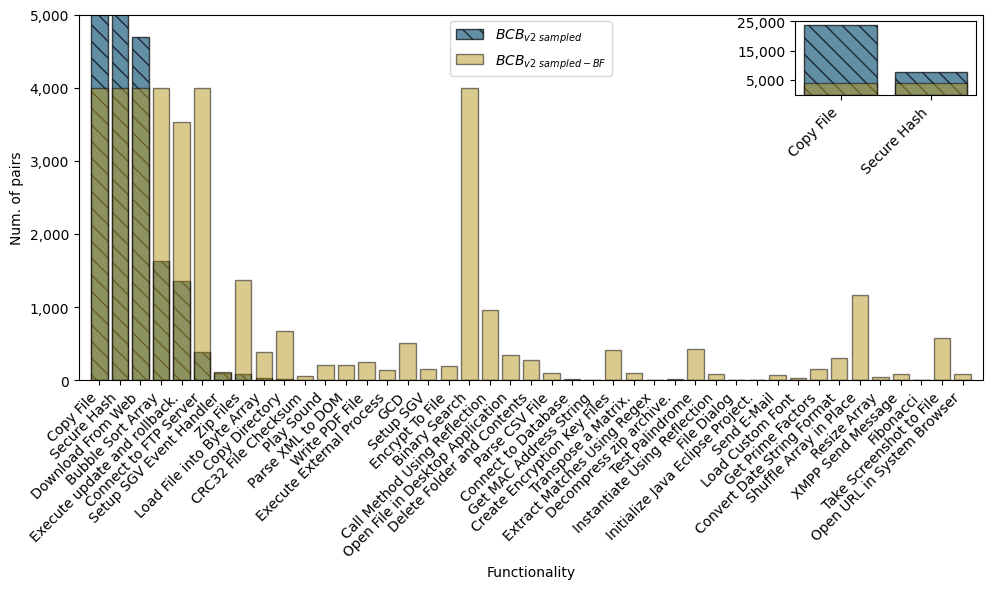

In [33]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

plt.figure(figsize=(10, 6))

# Plot the second histogram with a lower opacity, diagonal stripe fill pattern, and wider bars
plt.bar(range(len(d)), d['x2'], alpha=0.7, label=r'${BCB_{v2 \ sampled}}$', color='#1f5f80', hatch='\\\\', edgecolor='black')


# Plot the first histogram with a higher opacity, striped fill pattern, and narrower bars
plt.bar(range(len(d)), d['x1'], alpha=0.5, label=r'${BCB_{v2 \ sampled - BF}}$', color='#b8961d', edgecolor='black')


plt.xlabel('Functionality')
plt.ylabel('Num. of pairs')
plt.xticks(range(len(d)), d['fcn_name'], rotation=45, ha='right')
plt.ylim([0,5000])
plt.xlim([-1,43])
plt.legend(loc='upper center')

# Add a title and adjust the layout to fit a prestigious machine learning conference style
#plt.title('Number of pairs (clone and non-clone) in each functionality', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))


# Create an inset (zoomed-in) plot for positions 2 and 3
ax_inset = inset_axes(plt.gca(), width="20%", height="20%", loc=1)
# Plot the second histogram with a lower opacity, diagonal stripe fill pattern, and wider bars
plt.bar(range(len(d)), d['x2'], alpha=0.7, label=r'${BCB_{v2 \ sampled - BF}}$', color='#1f5f80', edgecolor='black', hatch='\\\\')

# Plot the first histogram with a higher opacity, striped fill pattern, and narrower bars
plt.bar(range(len(d)), d['x1'], alpha=0.5, label=r'${BCB_{v2 \ sampled}}$', color='#b8961d', edgecolor='black')



ax_inset.set_xlim(-0.5, 1.5)  # Focus on positions 2 and 3
ax_inset.set_ylim(0, 25000)  # Set a higher y-axis limit for the inset
ax_inset.set_xticks([0,1])
ax_inset.set_xticklabels(d['fcn_name'][0:2],  rotation=45, ha='right')
ax_inset.set_yticks([5000,15000,25000])
ax_inset.yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))  # Formatted y-axis labels



plt.savefig('/Users/konstantinos/Desktop/Clone Generalization/assets/num_of_pairs_per_functionality.pdf', format='pdf')

# Show the plot
plt.show()


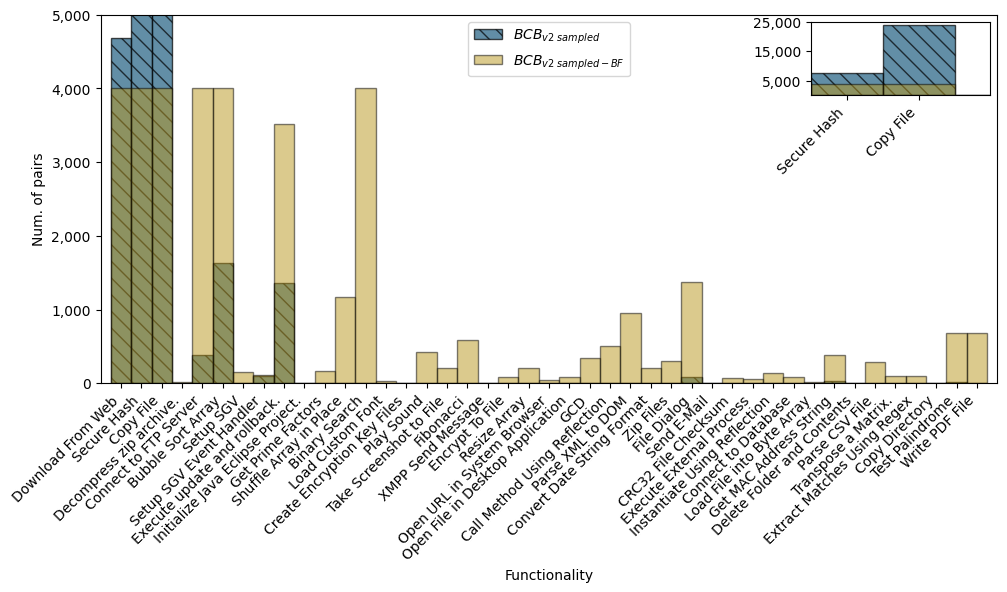

In [134]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

# Create the main plot
plt.figure(figsize=(10, 6))
plt.hist(functionality_ids, bins=len(functionalities_sql), alpha=0.7, label=r'${BCB_{v2 \ sampled}}$', color='#1f5f80' , edgecolor='black', hatch='\\\\', align='left')
plt.hist(f, bins=len(functionalities_sql), alpha=0.5, label=r'${BCB_{v2 \ sampled - BF}}$', color='#b8961d', edgecolor='black', align='left')
plt.xlabel('Functionality')
plt.ylabel('Num. of pairs')
plt.xticks(range(2, len(functionalities_sql['name'])+2), functionalities_sql['name'], rotation=45, ha='right')
plt.legend(loc='upper center')
plt.tight_layout()
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))
plt.ylim(0, 5000)  # Set y-axis limit for the main plot
plt.xlim(1,45)

# Create an inset (zoomed-in) plot for positions 2 and 3
ax_inset = inset_axes(plt.gca(), width="20%", height="20%", loc=1)
ax_inset.hist(functionality_ids, bins=len(functionalities_sql), alpha=0.7, color='#1f5f80', edgecolor='black', hatch='\\\\', align='left')
ax_inset.hist(f, bins=len(functionalities_sql), alpha=0.5, color='#b8961d', edgecolor='black', align='left')
# ax_inset.set_xlim(1.5, 5)  # Focus on positions 1,2 and 3
ax_inset.set_xlim(2.5, 5)  # Focus on positions 2 and 3
ax_inset.set_ylim(0, 25000)  # Set a higher y-axis limit for the inset
# ax_inset.set_xticks([2,3,4])
ax_inset.set_xticks([3,4])
# ax_inset.set_xticklabels(functionalities_sql['name'][0:3],  rotation=45, ha='right')
ax_inset.set_xticklabels(functionalities_sql['name'][1:3],  rotation=45, ha='right')
ax_inset.set_yticks([5000,15000,25000])
ax_inset.yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))  # Formatted y-axis labels


plt.savefig('/Users/konstantinos/Desktop/Clone Generalization/assets/num_of_pairs_per_functionality.pdf', format='pdf')

# Show the plot
plt.show()
